In [13]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as Data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## HW1 : 1.1 Simulate a Function

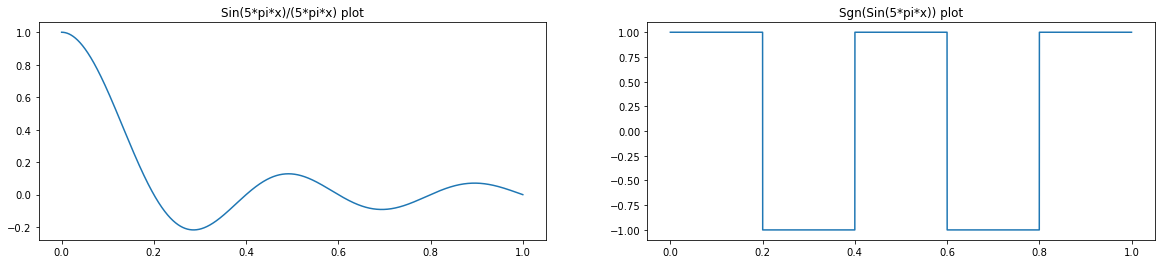

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=10, bias=True)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=5, bias=True)
  (13): ReLU()
  (14): Linear(in_features=5, out_features=1, bias=True)
)
Parameters:  571
Train Epoch: 100 [0/48000 (0%)]	Loss: 0.000221
Train Epoch: 100 [16000/48000 (33%)]	Loss: 0.000181
Train Epoch: 100 [32000/48000 (67%)]	Loss: 0.000178
Training Done!!!
 ****************************************************************************************************
Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=18, bias=Tru

In [15]:
def SinFunc(x_input):
    y = (np.sin(5*math.pi*x_input))/(5*math.pi*x_input) 
    return y

def SignFunc(x_input):
    y = np.sign(np.sin(5*math.pi*x_input))
    return y

X = np.linspace(1e-6, 1, 60000)
# y =  SignFunc(X)
y =  SinFunc(X)

X = X.reshape(-1,1)
y = y.reshape(-1,1)

fig, ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(X, SinFunc(X))
ax[0].set_title('Sin(5*pi*x)/(5*pi*x) plot')
ax[1].plot(X, SignFunc(X))
ax[1].set_title('Sgn(Sin(5*pi*x)) plot')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model0 = torch.nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

model1 = torch.nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 18),
            nn.ReLU(),
            nn.Linear(18, 15),
            nn.ReLU(),
            nn.Linear(15, 4),
            nn.ReLU(),
            nn.Linear(4,1)
        )

model2 = torch.nn.Sequential(
            nn.Linear(1, 190),
            nn.ReLU(),
            nn.Linear(190,1)
        )

models = [model0, model1, model2]

BATCH_SIZE=32
LEARNING_RATE = 1e-2
MAX_EPOCHS = 100

optimizers = []
criterions = []

for model in models:
    model.train()
    criterions.append(nn.MSELoss())
    optimizers.append(optim.SGD(model.parameters(), lr=LEARNING_RATE))
    

training_samples = Data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_data_loader = Data.DataLoader(training_samples, batch_size=BATCH_SIZE, shuffle=True)

test_samples = Data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_data_loader = Data.DataLoader(test_samples, batch_size=BATCH_SIZE, shuffle=True)

model_loss = []

for model,optimizer,criterion in zip(models,optimizers,criterions):
    print(model)
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Parameters: ",pytorch_total_params)
    
    train_loss = []
    
    for epoch in range(MAX_EPOCHS):
        avg_loss=[]
        correct = 0
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = Variable(data), Variable(target)
            
            optimizer.zero_grad()
            output = model(data.float())
            loss = criterion(output, target.float())
            
            #print(batch_idx, loss.data[0])
            loss.backward()
            
            optimizer.step()
            
            avg_loss.append(loss.item())
            #correct += (output == target.float()).sum()
                
            #if(epoch+1)%200==0 and batch_idx%100==0:
            if (epoch+1)%100==0 and batch_idx%500==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch+1, batch_idx * len(data), len(train_data_loader.dataset),100. * batch_idx / len(train_data_loader), np.average(avg_loss)))

        train_loss.append(np.average(avg_loss))
        
    model_loss.append(train_loss)
    print("Training Done!!!\n","*"*100)

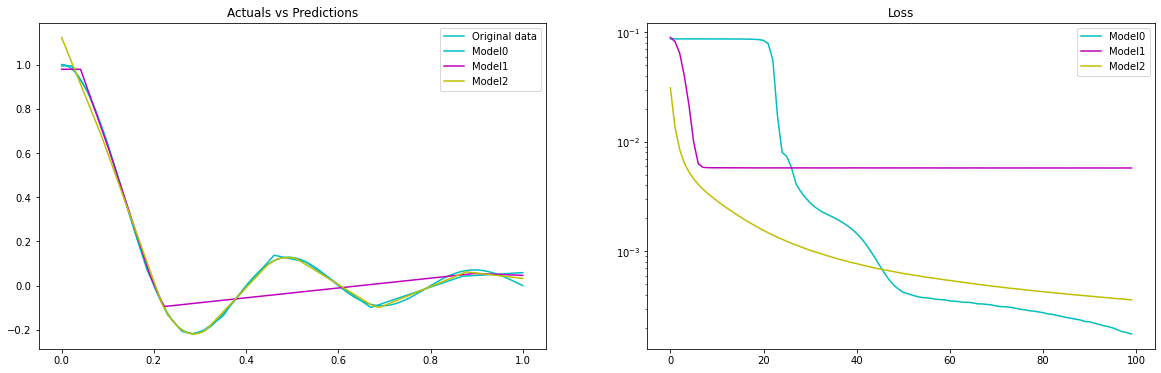

In [16]:

fig, ax = plt.subplots(1,2,figsize=(20,6))

Labels = ['Model0','Model1','Model2']
Colors = ['c', 'm', 'y']

ax[0].plot(np.linspace(1e-6, 1, 2000), SinFunc(np.linspace(1e-6, 1, 2000)), c='c', label='Original data')
ax[0].set_title("Actuals vs Predictions")

ax[1].set_title('Loss')
ax[1].set_yscale('log') 
for idx, model in enumerate(models):
    
    # plot  the predictions and the difference
    model.eval()

    prediction = model(Variable(torch.Tensor(np.linspace(1e-6, 1, 2000).reshape(-1,1))))
    prediction = prediction.data.numpy()

    ax[0].plot(np.linspace(1e-6, 1, 2000), prediction, c= Colors[idx], label=Labels[idx])

    ax[1].plot(model_loss[idx], c= Colors[idx], label=Labels[idx])

ax[0].legend()   
ax[1].legend()
plt.show()

In [17]:
train_loss

[0.03118604105586807,
 0.013624878348472218,
 0.008517849314336976,
 0.006399361845726768,
 0.00529899791503946,
 0.004595609247994919,
 0.004088192140916363,
 0.003702933854345853,
 0.003385101109199847,
 0.003131779740874966,
 0.002894854742490376,
 0.002694326197418074,
 0.002511910322122276,
 0.0023484554641569656,
 0.0021995193165106077,
 0.002066337493054258,
 0.0019427830949425697,
 0.0018302524589623014,
 0.0017332510598935186,
 0.0016363345565041528,
 0.001555791203941529,
 0.0014768752651677156,
 0.0014103491554657618,
 0.001344479544670321,
 0.0012897739751109233,
 0.001234990680590272,
 0.0011859403114843493,
 0.00114325100571538,
 0.001099175879227308,
 0.0010605750285321847,
 0.001022945934246915,
 0.0009909803970949724,
 0.000961687189002987,
 0.0009320002548241367,
 0.0009046027903677896,
 0.0008778177862986922,
 0.0008539450365157487,
 0.0008322539803533194,
 0.000810545691405423,
 0.000788802987721283,
 0.0007728771936381236,
 0.0007525587725491884,
 0.000737272663274

## HW1 : 1.1 Train on Actual Tasks - MNIST

In [18]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [19]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

In [20]:
print(train_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


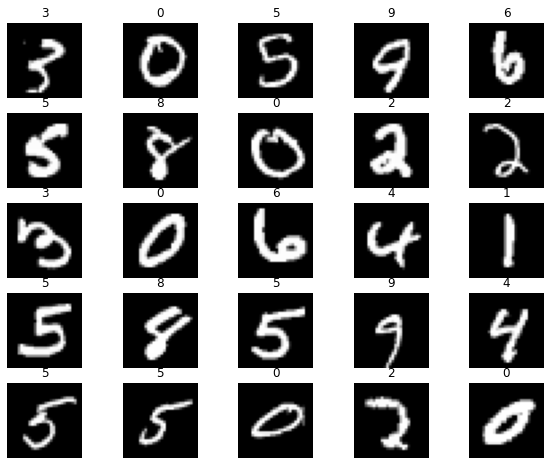

In [21]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [22]:
loaders = {'train': Data.DataLoader(train_data,
                                               batch_size=100,
                                               shuffle=True,
                                               num_workers=1),
          'test': Data.DataLoader(test_data,
                                             batch_size=100,
                                             shuffle=True,
                                             num_workers=1)
          }

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x14d9a86b1d00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x14d9a86b1700>}

In [23]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        x = self.conv1(x)
        # flatten the output of conv2 to (batch_size, 16 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

class CNN0(nn.Module):
    def __init__(self):
        super(CNN0, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten the output of conv2 to (batch_size, 128 * 1 * 1)
        x = x.view(-1, 128)  
        output = self.out(x)
        return output, x    # return x for visualization

class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1), x
    
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1), X
    
class DNN0(nn.Module):
    def __init__(self):
        super(DNN0, self).__init__()
        self.linear1 = nn.Linear(784,100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,10)       
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        for i in range(15):
            X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1), X
    
class DNN2(nn.Module):
    def __init__(self):
        super(DNN2, self).__init__()
        self.linear1 = nn.Linear(784,280)
        self.linear2 = nn.Linear(280,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X
    
cnn_models = [CNN0(), CNN1(), CNN2(), CNN3()]
dnn_models = [DNN0(), DNN1(), DNN2()]

In [24]:
loss_functions = []
optimizers = []
num_epochs = 30

for model in cnn_models:
    model.train()
    optimizers.append(optim.Adam(model.parameters(), lr = 0.01))
    loss_functions.append(nn.CrossEntropyLoss())

model_loss=[]
model_accuracy=[]
    
for model, optimizer, loss_func in zip(cnn_models,optimizers,loss_functions):
    print(model)
    # Train the model
    total_step = len(loaders['train'])
    
    train_loss =[]
    train_acc = []
    for epoch in range(num_epochs):
        correct=0
        b_loss=[]
        b_acc=[]
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images) # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step() 
            
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted==b_y).sum()
            
            b_loss.append(loss.item())
            b_acc.append(float(correct)*100/float(100*(i+1)))
            
            if (i+1)%200==0 and epoch%2==0:
                print ('Epoch done[{}/{}], Step [{}/{}], Loss: {:.4f}, and Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, i + 1, total_step, b_loss[-1],b_acc[-1]))
        train_loss.append(np.average(b_loss))
        train_acc.append(np.average(b_acc))
     
    model_loss.append(train_loss)
    model_accuracy.append(train_acc)
    print("Training completed!!!\n","*"*100)
    

CNN0(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch done[1/30], Step [200/600], Loss: 0.1051, and Accuracy: 78.325%
Epoch done[1/30], Step [400/600], Loss: 0.0922, and A

In [26]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
#             images = Variable(images).view(-1,784)
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

for model in cnn_models:
    test(model)

Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.98


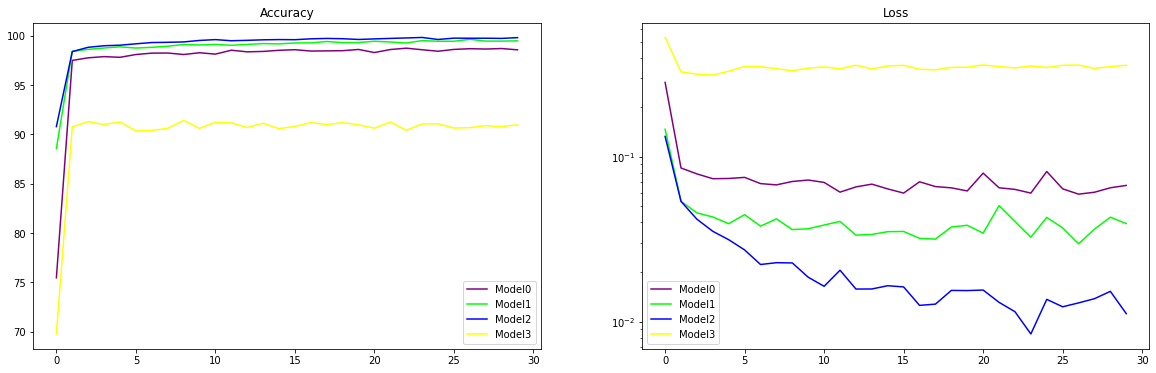

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

Labels = ['Model0','Model1','Model2','Model3']
Colors = ['#800080', '#00FF00', '#0000FF', '#FFFF00']

ax[0].set_title("Accuracy")
ax[1].set_title('Loss')
ax[1].set_yscale('log') 

for idx, model in enumerate(cnn_models):

    ax[0].plot(model_accuracy[idx], c= Colors[idx], label=Labels[idx])

    ax[1].plot(model_loss[idx], c= Colors[idx], label=Labels[idx])

ax[0].legend()   
ax[1].legend()
plt.show()

### PCA On MNIST Dataset

In [28]:
copy_train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

copy_test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

In [29]:
print(copy_train_data.targets.size())
print(copy_train_data.data.size())
print(type(copy_train_data.data))

torch.Size([60000])
torch.Size([60000, 28, 28])
<class 'torch.Tensor'>


In [30]:
train_data_features = copy_train_data.data.view(-1,784).numpy()
train_data_targets = copy_train_data.targets.numpy()

test_data_features = copy_test_data.data.view(-1,784).numpy()
test_data_targets = copy_test_data.targets.numpy()

print(train_data_features.shape)
print(train_data_targets.shape)
print(test_data_features.shape)
print(test_data_targets.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_df = scaler.fit_transform(train_data_features)
std_df.shape

(60000, 784)

In [32]:
covar_mat = np.matmul(std_df.T, std_df)
covar_mat.shape

(784, 784)

In [33]:
from scipy.linalg import eigh
values, vectors = eigh(covar_mat, eigvals = (782, 783))
print("Dimensions of Eigen vector:", vectors.shape)
vectors = vectors.T
print("Dimensions of Eigen vector:", vectors.shape)

Dimensions of Eigen vector: (784, 2)
Dimensions of Eigen vector: (2, 784)


In [34]:
final_df = np.matmul(vectors, std_df.T)
print("vectros:", vectors.shape, "n", "std_df:", std_df.T.shape, "n", "final_df:", final_df.shape)

vectros: (2, 784) n std_df: (784, 60000) n final_df: (2, 60000)


In [35]:
import pandas as pd

final_dfT = np.vstack((final_df, train_data_targets)).T
dataFrame = pd.DataFrame(final_dfT, columns = ['pca_1', 'pca_2', 'label'])
dataFrame

,pca_1,pca_2,label
0,-4.814790,-0.922159,5.0
1,-7.754403,8.708977,0.0
2,9.431338,2.328389,4.0
3,-3.746318,-6.582173,1.0
4,3.133297,-5.183251,9.0
...,...,...,...
59995,-5.119129,-2.039339,8.0
59996,-6.498440,0.607841,3.0
59997,-3.230564,-3.777212,5.0
59998,-4.948125,1.722369,6.0


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


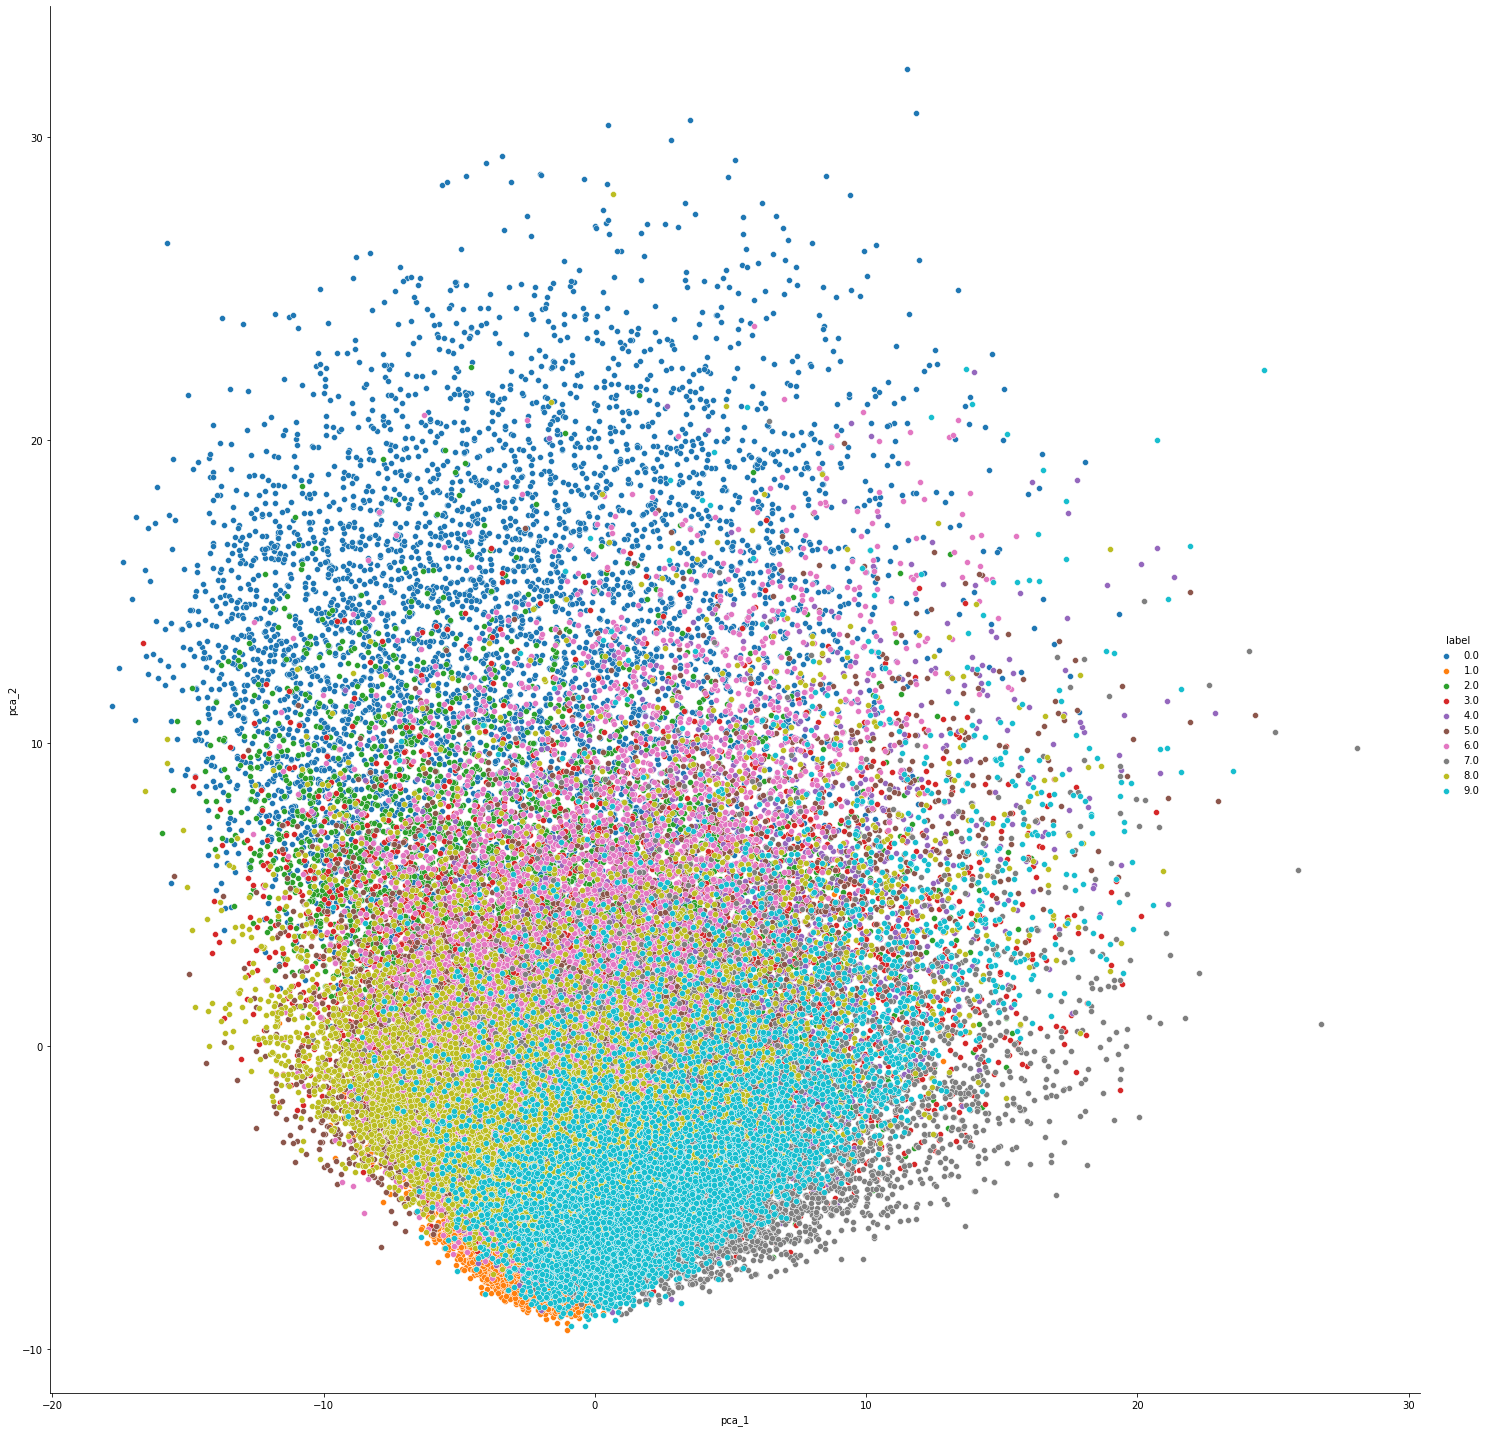

In [36]:
import seaborn as sns

sns.FacetGrid(dataFrame, hue = 'label', size = 20).map(sns.scatterplot, 'pca_1', 'pca_2').add_legend()
plt.show()

In [37]:
train_data_new = np.c_[train_data_features, train_data_targets]
test_data_new = np.c_[test_data_features, test_data_targets]

In [38]:
print(train_data_new.shape)
print(test_data_new.shape)

(60000, 785)
(10000, 785)
